# Variability in the Arm Endpoint Stiffness

In this notebook, we will calculate the feasible endpoint stiffness of a
simplified arm model for an arbitrary movement. The calculation of the feasible
muscle forces and the generation of the movement is presented in
feasible_muscle_forces.ipynb. The steps are as follows:

1. Generate a movement using task space projection
2. Calculate the feasible muscle forces that satisfy the movement
3. Calculate the feasible endpoint stiffness

In [1]:
# notebook general configuration

%load_ext autoreload
%autoreload 2

# imports and utilities
import numpy as np
import sympy as sp
from IPython.display import display, Image
sp.interactive.printing.init_printing()

import logging
logging.basicConfig(level=logging.INFO)

# plot
%matplotlib inline
from matplotlib.pyplot import *
rcParams['figure.figsize'] = (10.0, 6.0)

# utility for displaying intermediate results
enable_display  = True
def disp(*statement):
    if (enable_display):
        display(*statement)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Step 1: Task Space Inverse Dynamics Controller

The task space position ($x_t$) is given as a function of the generalized
coordinates ($q$)


\begin{equation}\label{equ:task-position}
x_t = g(q), x_t \in \Re^{d}, q \in \Re^{n}, d \leq n
\end{equation}


The first and second derivatives with respect to time (the dot notation depicts
a derivative with respect to time) are given by


\begin{equation}\label{equ:task-joint-vel}
  \dot{x}_t = J_t(q) \dot{q}, \; J_t(q) =
  \begin{bmatrix}
  \frac{\partial g_1}{\partial q_1} & \cdots & \frac{\partial g_1}{\partial q_n} \\
      \vdots & \ddots & \vdots \\
      \frac{\partial g_d}{\partial q_1} & \cdots & \frac{\partial g_d}{\partial q_n}
  \end{bmatrix}
  \in \Re^{d\times n}
\end{equation}


\begin{equation}\label{equ:task-joint-acc}
  \ddot{x}_t = \dot{J}_t\dot{q} + J_t\ddot{q}
\end{equation}


The task Jacobian defines a dual relation between motion and force
quantities. The virtual work principle can be used to establish the link between
task and join space forces (augmented by the null space)


\begin{equation}\label{equ:joint-task-forces-vw}
  \begin{aligned}
    \tau^T \delta q &= f_t^T \delta x_t \\
    \tau^T \delta q &= f_t^T J_t \delta q \\
    \tau &= J_t^T f_t + N_{J_t} \tau_0, \; N_{J_t} = (I - J_t^T \bar{J}_t^T)
  \end{aligned}
\end{equation}


where $N_{J_t} \in \Re^{n \times n}$ represents the right null space of $J_t$
and $\bar{J}_t$ the generalized inverse. Let the joint space equations of motion
(EoMs) have the following form

 
\begin{equation}\label{equ:eom-joint-space}
  \begin{gathered}
    M(q) \ddot{q} + f(q, \dot{q}) =  \tau  \\
    f(q, \dot{q}) = \tau_g(q) + \tau_c(q, \dot{q}) + \tau_{o}(q, \dot{q}) 
  \end{gathered}
\end{equation}


where $M \in \Re^{n \times n}$ denotes the symmetric, positive definite joint
space inertia mass matrix, $n$ the number of DoFs of the model and ${q, \dot{q},
\ddot{q}} \in \Re^{n}$ the joint space generalized coordinates and their
derivatives with respect to time. The term $f \in \Re^{n}$ is the sum of all
joint space forces, $\tau_g \in \Re^{n}$ is the gravity, $\tau_c \in \Re^{n}$
the Coriolis and centrifugal and $\tau_{o} \in \Re^{n}$ other generalized
forces. Term $\tau \in \Re^{n}$ denotes a vector of applied generalized forces
that actuate the model.


We can project the joint space EoMs in the task space by multiplying both sides
from the left with $J_t M^{-1}$


\begin{equation}\label{equ:eom-task-space}
  \begin{gathered}
    J_t M^{-1}M \ddot{q} + J_t M^{-1}f = J_t M^{-1}\tau \\
    \ddot{x}_t - \dot{J}_t\dot{q} + J_t M^{-1}f = J_t M^{-1} (J^T_t f_t + N_{J_t} \tau_0) \\
    \Lambda_t(\ddot{x}_t + b_t) + \bar{J}_t^T f = f_t 
  \end{gathered}
\end{equation}


where $\Lambda_t=(J_tM^{-1}J_t^T)^{-1} \in \Re^{d \times d}$ represents the task
space inertia mass matrix, $b_t = - \dot{J}_t\dot{q}$ the task bias term and
$\bar{J}_t^T = \Lambda_m RM^{-1} \in \Re^{d \times n}$ the generalized inverse
transpose of $J_t$ that is used to project joint space quantities in the task
space. Note that $\bar{J}_t^T N_{J_t} \tau_0 = 0$.

The planning will be performed in task space in combination with a Proportional
Derivative (PD) tracking scheme

\begin{equation}\label{equ:pd-controller}
  \ddot{x}_t = \ddot{x}_d + k_p (x_d - x_t) + k_d (\dot{x}_d - x_t)
\end{equation}

where $x_d, \dot{x}_d, \ddot{x}_d$ are the desired position, velocity and
acceleration of the task and $k_p = 50, k_d = 5$ the tracking gains.

The desired task goal is derived from a smooth sigmoid function that produces
bell-shaped velocity profiles in any direction around the initial position of
the end effector


\begin{equation}\label{equ:sigmoid}
  \begin{gathered}
    x_d(t) = [x_{t,0}(0) + a (tanh(b (t - t_0 - 1)) + 1) / 2, x_{t,1}(0)]^T, \; 
    \dot{x}_d(t) = \frac{d x_d(t)}{dt}, \; \ddot{x}_d(t) = \frac{d \dot{x}_d(t)}{dt} \\
        x_d^{'} = H_z(\gamma) x_d, \; \dot{x}_d^{'} = H_z(\gamma) \dot{x}_d,
    \; \ddot{x}_d^{'} = H_z(\gamma) \ddot{x}_d  
  \end{gathered}
\end{equation}

where $x_{t, 0}$, $x_{t, 1}$ represent the $2D$ components of $x_t$, $a = 0.3$,
$b = 4$ and $t_0 = 0$. Different directions of movement are achieved by
transforming the goals with $H_z(\gamma)$, which defines a rotation around
the $z$-axis of an angle $\gamma$.

In [2]:
# import necessary modules
from model import ArmModel
from projection import TaskSpace
from controller import TaskSpaceController
from simulation import Simulation

In [3]:
# construct model gravity disabled to improve execution time during numerical
# integration note that if enabled, different PD gains are required to track the
# movement accurately
model = ArmModel(use_gravity=0, use_coordinate_limits=1, use_viscosity=1)
model.pre_substitute_parameters()

'x_t = '

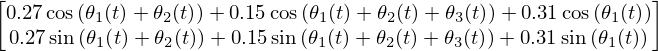

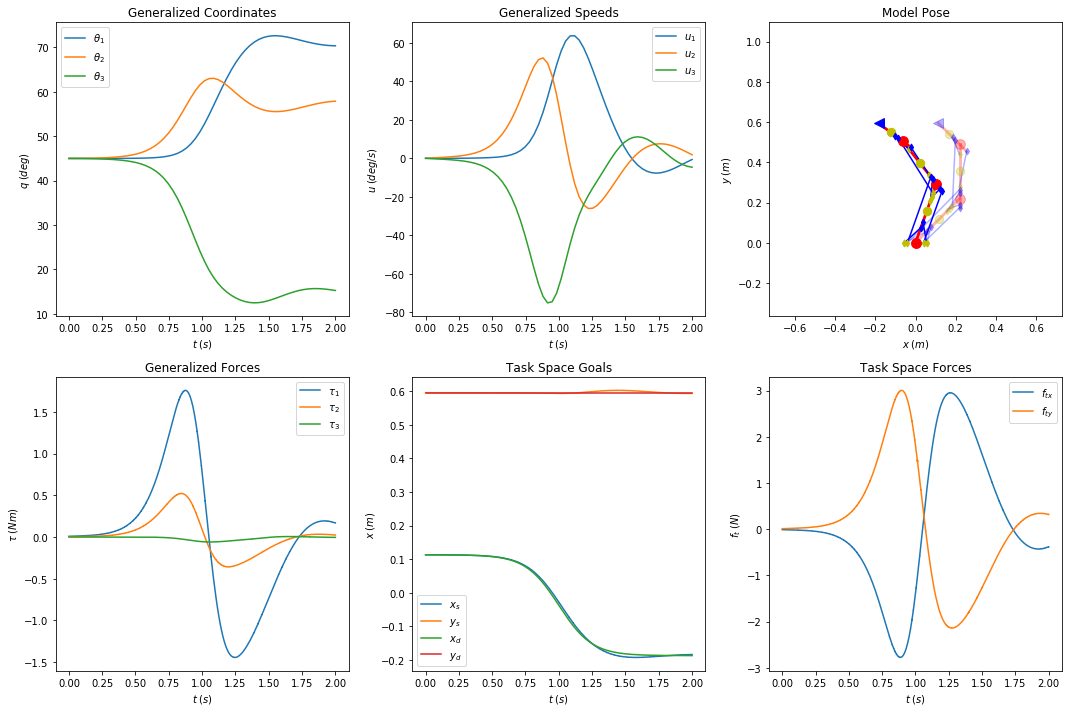

In [4]:
# simulation parameters
t_end = 2.0
angle = np.pi  # direction of movement
fig_name = 'results/feasible_stiffness/feasible_forces_ts180'

# define the end effector position in terms of q's
end_effector = sp.Matrix(model.ee)
disp('x_t = ', end_effector)

# task space controller
task = TaskSpace(model, end_effector)
controller = TaskSpaceController(model, task, angle=angle)

# numerical integration
simulation = Simulation(model, controller)
simulation.integrate(t_end)

# plot simulation results
fig, ax = subplots(2, 3, figsize=(15, 10))
simulation.plot_simulation(ax[0])
controller.reporter.plot_task_space_data(ax[1])
fig.tight_layout()
fig.savefig(fig_name + '.pdf', format='pdf', dpi=300)
fig.savefig(fig_name + '.eps', format='eps', dpi=300)

## Step 2: Calculation of the Feasible Muscle Force Space

The feasible muscle forces are calculated below. Initially, the moment arm and
maximum muscle force quantities are computed for each instance of the
movement. Then the following inequality is formed assuming a linear muscle model

\begin{equation}\label{equ:linear-muscle-null-space-inequality}
  \begin{gathered}
    f_m = f_{max} \circ a_m = f_m^{\parallel} +
    N_{R} f_{m0},\; 0 \preceq a_m \preceq 1
    \rightarrow \\
    \begin{bmatrix}
      - N_{R} \\
      \hdashline
      N_{R}
    \end{bmatrix}
    f_{m0} \preceq
    \begin{bmatrix}
      f_m^{\parallel} \\
      \hdashline
      f_{max} - f_m^{\parallel}
    \end{bmatrix} \\
    Z f_{m0} \preceq \beta
  \end{gathered}
\end{equation}

where $a_m \in \Re^{m}$ represents a vector of muscle activations, $f_{max} \in
\Re^{m}$ a vector specifying the maximum muscle forces, $\circ$ the Hadamard
(elementwise) product, $f_m^{\parallel}$ the particular muscle force solution
that satisfies the action, $N_{R}$ the moment arm null space and $f_{m0}$ the
null space forces.

The next step is to sample the inequality $Z f_{m0} \leq \beta$. This is the
bottleneck of the analysis. The *convex_bounded_vertex_enumeration* uses the
lsr method, which is a vertex enumeration algorithm for finding the vertices
of a polytope in $O(v m^3)$.

In [5]:
# import necessary modules
from analysis import FeasibleMuscleSetAnalysis

# initialize feasible muscle force analysis
feasible_muscle_set = FeasibleMuscleSetAnalysis(model, controller.reporter)

## Step 3: Calculate the Feasible Task Stiffness

In the following section, we will introduce a method for calculating the
feasible muscle forces that satisfy the motion and the physiological muscle
constraints. As the muscles are the main actors of the system, it is important
to examine the effect of muscle redundancy on the calculation of limbs'
stiffness.

The muscle stiffness is defined as

\begin{equation}\label{equ:muscle-stiffness}
  K_m = \frac{\partial f_m}{\partial l_{m}},\;  K_m \in \Re^{m \times m}
\end{equation}

where $f_m \in \Re^{m}$ represents the muscle forces, $l_{m} \in \Re^{m}$ the
musculotendon lengths and $m$ the number of muscles. The joint stiffness is
defined as

\begin{equation}\label{equ:joint-stiffness}
  K_j = \frac{\partial \tau}{\partial q},\; K_j \in \Re^{n \times n}
\end{equation}

where $\tau \in \Re^{n}$, $q \in \Re^{n}$ are the generalized forces and
coordinates, respectively and $n$ the DoFs of the system. Finally, the task
stiffness is defined as

\begin{equation}\label{equ:task-stiffness}
  K_t = \frac{\partial f_t}{\partial x_t},\; K_t \in \Re^{d \times d}
\end{equation}

where $f_t \in \Re^{d}$ denotes the forces, $x_t \in \Re^{d}$ the positions and
$d$ the DoFs of the task.

The derivation starts with a model for computing the muscle stiffness matrix
$K_m$. The two most adopted approaches are to either use the force-length
characteristics of the muscle model or to approximate it using the definition of
the short range stiffness, where the latter is shown to explain most of the
variance in the experimental measurements. The short range stiffness is
proportional to the force developed by the muscle ($f_m$)

\begin{equation}\label{equ:short-range-stiffness}
  k_{s} = \gamma \frac{f_m}{l_m^o}
\end{equation}

where $\gamma = 23.4$ is an experimentally determined constant and $l_m^o$ the
optimal muscle length. This definition will be used to populate the diagonal
elements of the muscle stiffness matrix, whereas inter-muscle coupling
(non-diagonal elements) will be assumed zero since it is difficult to measure
and model in practice.

The joint stiffness is related to the muscle stiffness through the following
relationship

\begin{equation}\label{equ:joint-muscle-stiffness}
    K_j = -\frac{\partial R^T}{\partial q} \bullet_2 f_m - R^T K_m R
\end{equation}

where the first term captures the varying effect of the muscle moment arm ($R
\in \Re^{m \times n}$), while the second term maps the muscle space stiffness to
joint space. The notation $\bullet_2$ denotes a product of a rank-3 tensor
($\frac{\partial R^T}{\partial q} \in \Re^{n \times m \times n}$, a 3D matrix)
and a rank-1 tensor ($f_m \in \Re^{m}$, a vector), where the index $2$ specifies
that the tensor dimensional reduction (by summation) is performed across the
second dimension, resulting in a reduced rank-2 tensor of dimensions $n \times
n$.

In a similar manner, the task stiffness is related to the muscle stiffness
through the following relationship

\begin{equation}\label{equ:task-muscle-stiffness}
  K_t  = -J_t^{+T} \left(\frac{\partial J_t^T}{\partial q} \bullet_2
    f_t + \frac{\partial R^T}{\partial q} \bullet_2 f_m + R^T
    K_m R\right) J_t^{+}
\end{equation}
  
where the task Jacobian matrix ($J_t \in \Re^{d \times n}$) describes the
mapping from joint to task space ($\Re^{n} \rightarrow \Re^{d}$), $+$ stands for
the Moore-Penrose pseudoinverse and $+T$ the transposed pseudoinverse operator.

Algorithm for calculating the feasible joint stiffness:

**Step 1:** Calculate the feasible muscle forces $f_m^{\oplus}$ that satisfy the
task and the physiological muscle constraints


**Step 2:** Calculate the muscle stiffness matrix $K_m$ using the short range
stiffness model


\begin{equation*}\label{equ:short-range-stiffness-2}
  k_s = \gamma \frac{f_m}{l_m^o},\; \gamma = 23.4
\end{equation*}


**Step 3:** Calculate the task $K_t$ and joint $K_j$ stiffness

\begin{equation*}
  \begin{gathered}
    K_j = -\frac{\partial R^T}{\partial q} \bullet_2 f_m - R^T K_m R \\
    K_t  = -J_t^{+T} \left(\frac{\partial J_t^T}{\partial q} \bullet_2
    f_t + \frac{\partial R^T}{\partial q} \bullet_2 f_m + R^T
    K_m R\right) J_t^{+} 
  \end{gathered}
\end{equation*}

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating feasible stiffness properties ...


100%|██████████| 10/10 [00:31<00:00,  3.11s/it]


convert -delay 100.0 -loop 0 results/feasible_stiffness/feasible_stiffness_ts180_*.png results/feasible_stiffness/feasible_stiffness_ts180_anim.gif


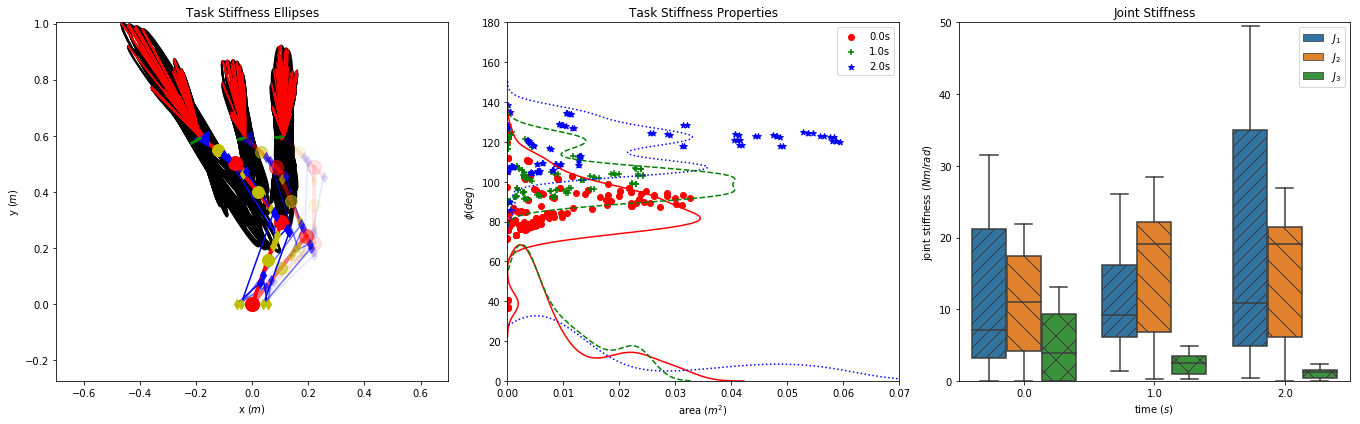

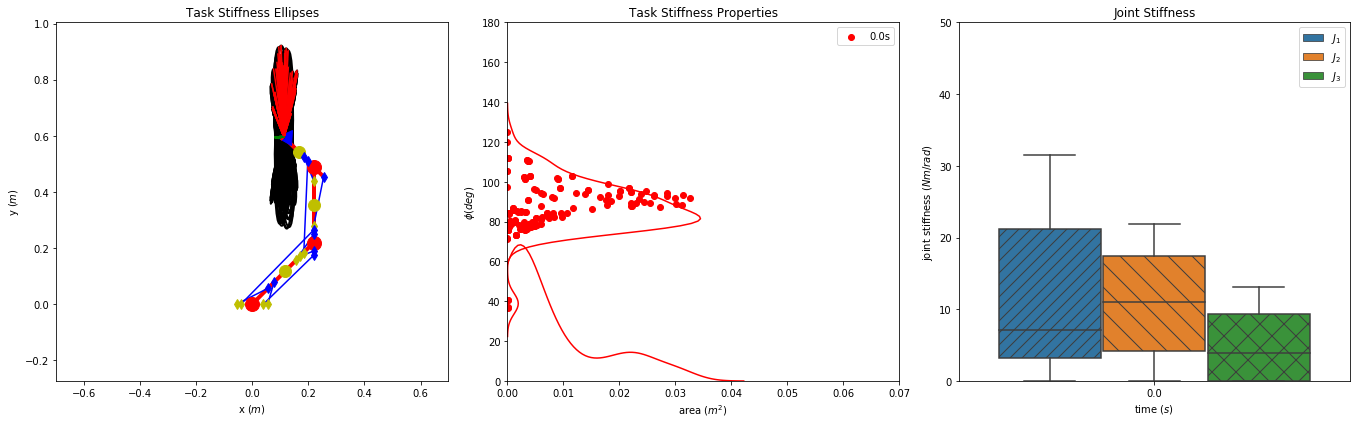

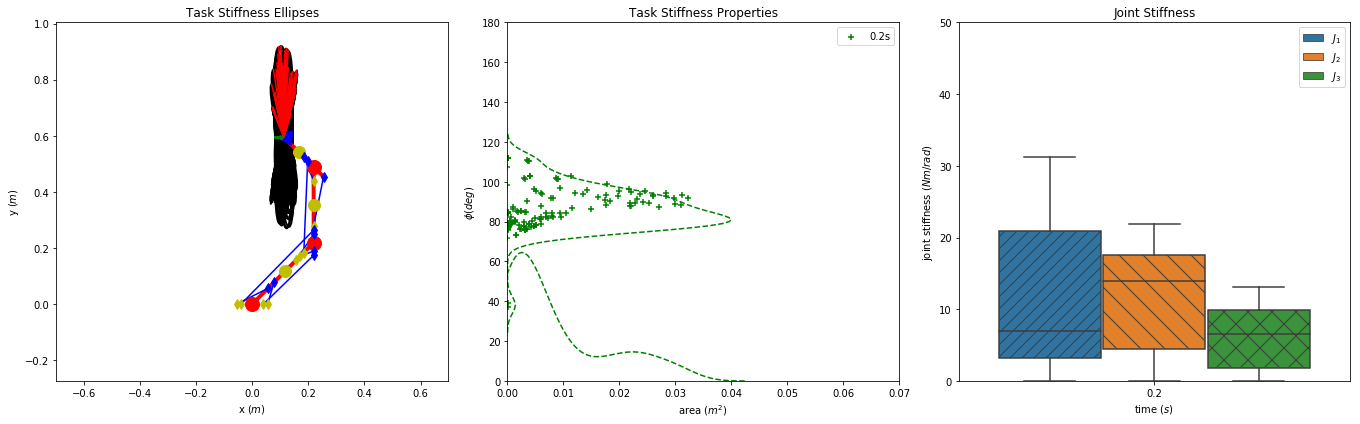

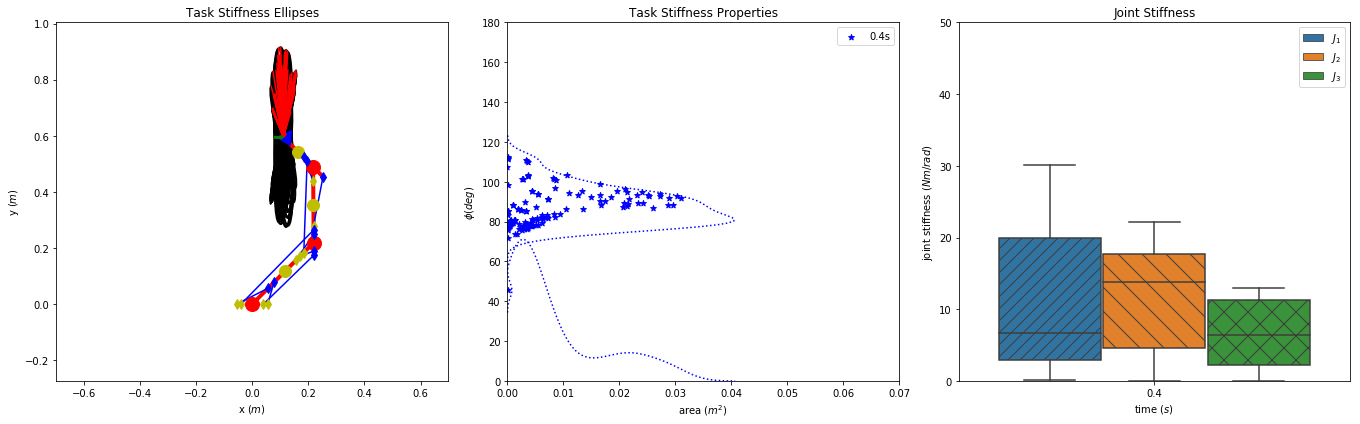

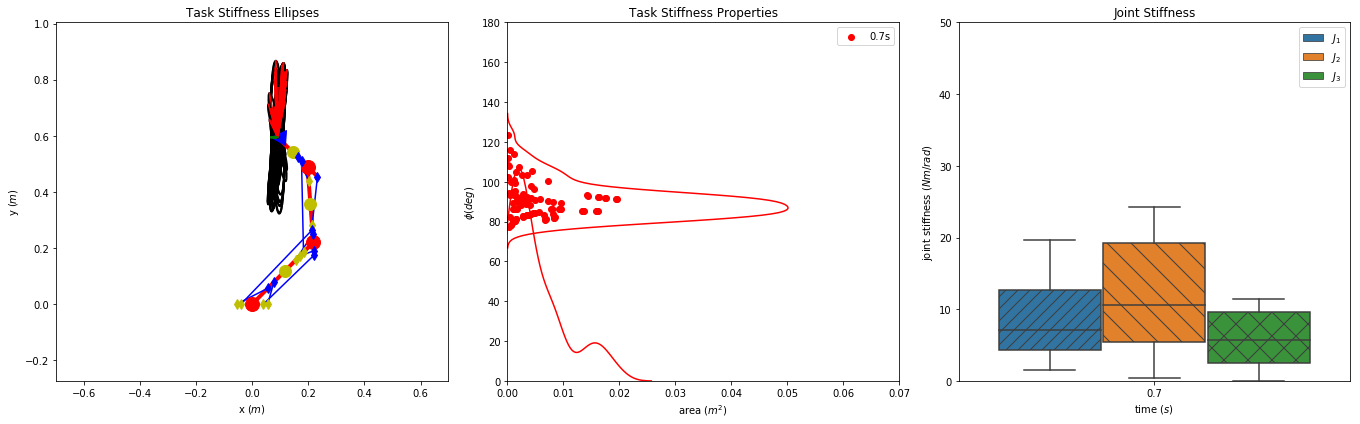

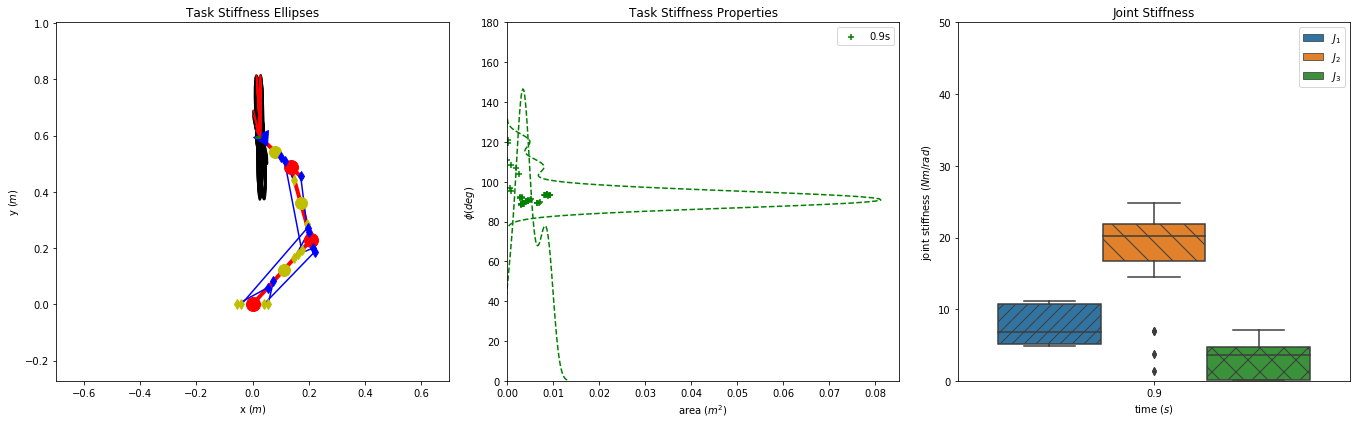

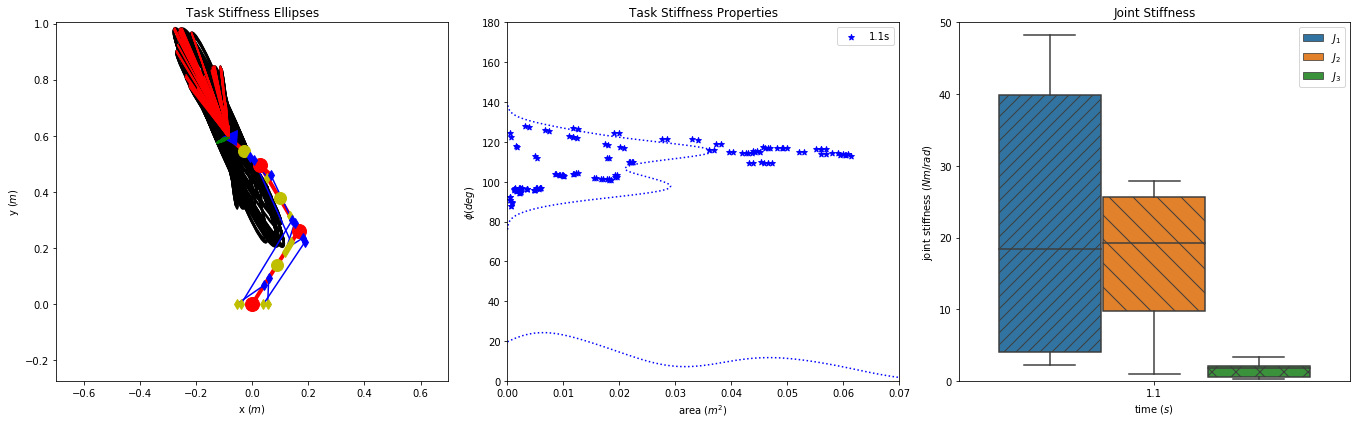

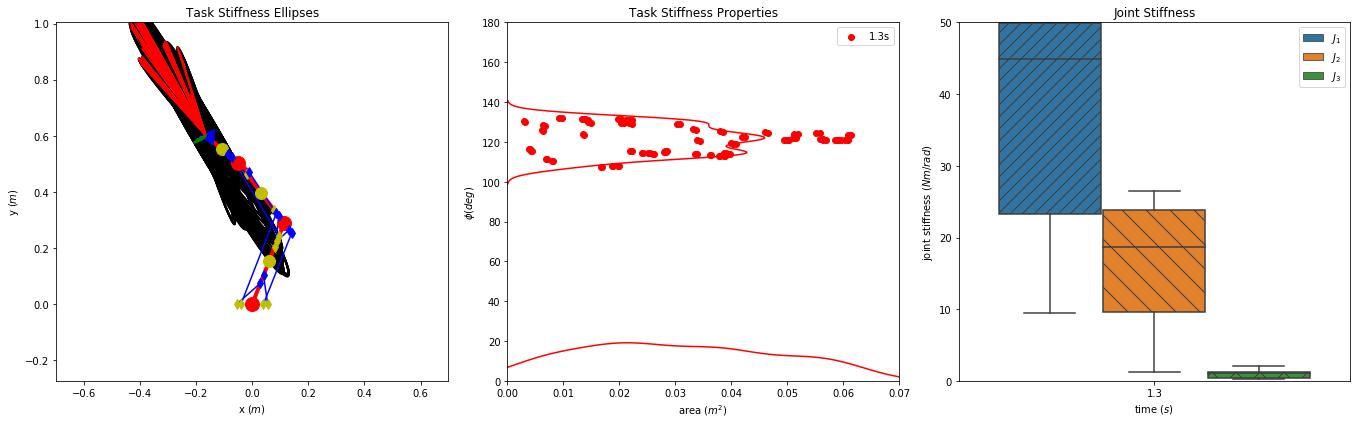

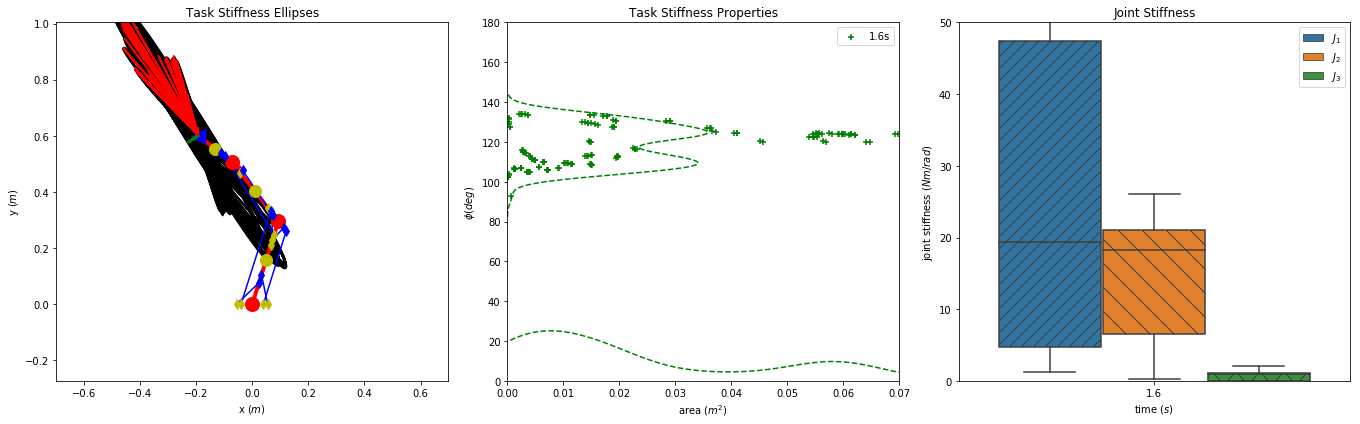

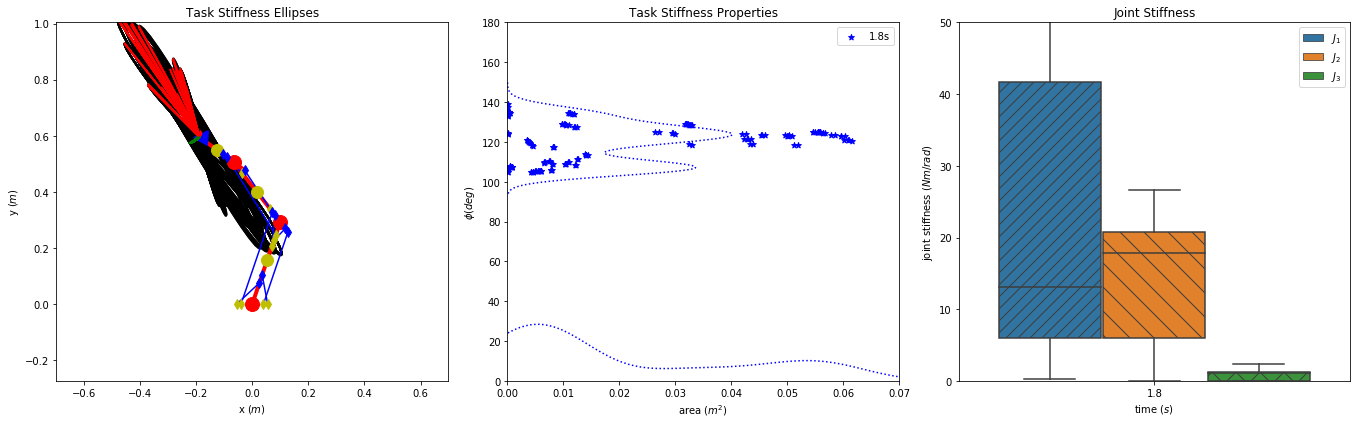

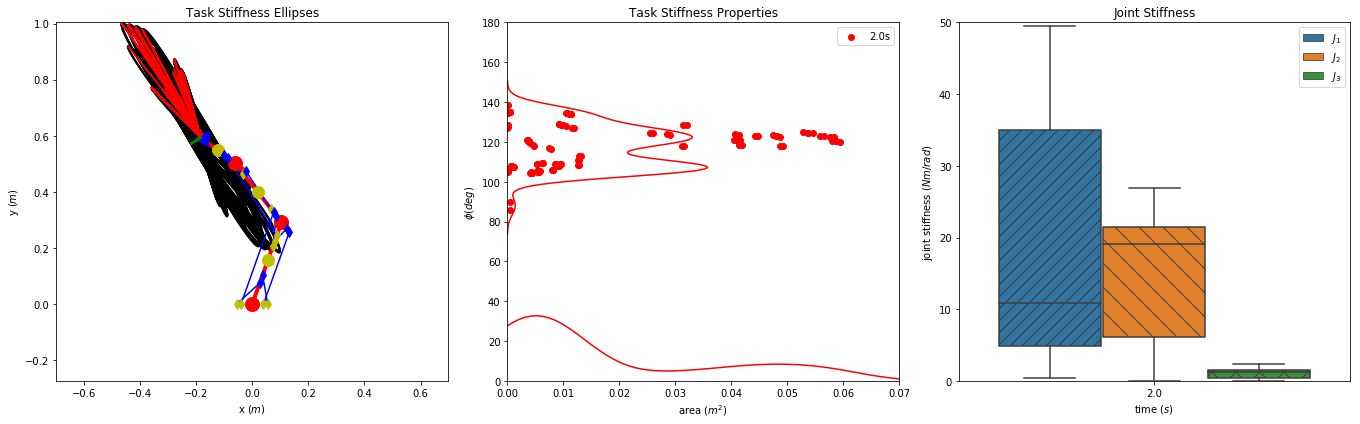

In [6]:
# import necessary modules
from analysis import StiffnessAnalysis
from util import calculate_stiffness_properties

base_name = 'results/feasible_stiffness/feasible_stiffness_ts180_'

# initialize stiffness analysis
stiffness_analysis = StiffnessAnalysis(model, task, controller.reporter,
                                       feasible_muscle_set)

# calculate feasible stiffness
calculate_stiffness_properties(stiffness_analysis, base_name, 0, t_end, 0.2, 500)

In [7]:
Image(url=base_name + 'anim.gif')

The left diagram shows the feasible major and minor axes of the endpoint
stiffness using scaled ($\text{scaling} = 0.0006$) ellipses (ellipses are
omitted for visibility reasons). The ellipse is a common way to visualize the
task stiffness, where the major axis (red) of the ellipse is oriented along the
maximum stiffness and the area is proportional to the determinant of $K_t$,
conveying the stiffness amplitude. The stiffness capacity (area) is increased in
the last pose, since the arm has already reached its final position and muscle
forces are not needed for it to execute any further motion. The second diagram
(middle) depicts the distribution of ellipse parameters (area and orientation
$\phi$). Finally, the rightmost box plot shows the feasible joint stiffness
distribution at three distinct time instants. Experimental measurements have
showed that the orientation of stiffness ellipses varies in a range of about
$30^{\circ}$. While our simulation results confirm this, they also reveal a
tendency of fixation towards specific directions for higher stiffness
amplitudes. The large variation of feasible stiffness verifies that this type of
analysis conveys important findings that complement experimental observations.